In [22]:
import os
import requests
import torch
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import sys
print(sys.executable)  # just to see which Python the notebook is using

# Install into THIS Python, not some other one
!{sys.executable} -m pip install --upgrade diffusers[torch] transformers
from diffusers import StableUnCLIPImg2ImgPipeline
from transformers import CLIPTextModelWithProjection, CLIPTokenizer
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

/opt/conda/bin/python
Defaulting to user installation because normal site-packages is not writeable


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# ──────────────────────────────────────────────────────────────
# 1.  Load unCLIP – vision side only (projection_dim = 1024)   ─
# ──────────────────────────────────────────────────────────────
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "sd2-community/stable-diffusion-2-1-unclip",
    torch_dtype=torch.float16,
    variant="fp16"
).to(device)

vision_encoder = pipe.image_encoder         

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

In [25]:
openclip_repo = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"     # projection_dim = 1024 :contentReference[oaicite:0]{index=0}
tokenizer = CLIPTokenizer.from_pretrained(openclip_repo)
text_encoder = CLIPTextModelWithProjection.from_pretrained(
    openclip_repo,
    torch_dtype=torch.float16
).to(device)

# optional: stuff them into the pipe so `pipe.tokenizer` etc. work
pipe.tokenizer, pipe.text_encoder = tokenizer, text_encoder

In [26]:
def embed_images(paths, batch_size=8):
    """Return (N,1024) image embeddings"""
    out, fe, enc = [], pipe.feature_extractor, pipe.image_encoder
    for i in range(0, len(paths), batch_size):
        print(f"Batch {i}/{len(paths)}")
        imgs = [Image.open(p).convert("RGB") for p in paths[i:i + batch_size]]
        px   = fe(imgs, return_tensors="pt").pixel_values.to(enc.device, enc.dtype)
        with torch.no_grad():
            v = enc(px)[0]                              # (B,1024)
        out.append(v)
    return torch.cat(out)  # (N,1024)

In [27]:
# ──────────────────────────────────────────────────────────────
#  Deal with file structure and get working paths
# ──────────────────────────────────────────────────────────────
root = "THINGS_animalgroups"

# collect all jpgs and keep their group (top-level folder)
groupedimages = {}

for group in os.listdir(root):
    group_dir = os.path.join(root, group)
    groupedimages[group] = []

    #go into animal name from category
    for animal in os.listdir(group_dir):
        animal_dir = os.path.join(group_dir, animal)
        if not os.path.isdir(animal_dir):
            continue

        # animal images inside animal files
        for fname in os.listdir(animal_dir):
            if fname.lower().endswith(".jpg"):
                full_path = os.path.join(animal_dir, fname)
                groupedimages[group].append(full_path)
# test
for g, imgs in groupedimages.items():
    print(g, "->", len(imgs), "images")

mammals -> 80 images
sea_animals -> 71 images
reptiles -> 86 images
bugs -> 88 images
birds -> 97 images


In [28]:
#map each group
groups = sorted(groupedimages.keys())   # deterministic order
group_to_idx = {g: i for i, g in enumerate(groups)}
print("Label mapping:", group_to_idx)

all_paths = []
all_labels = []

for group, paths in groupedimages.items():
    for p in paths:
        all_paths.append(p)
        all_labels.append(group_to_idx[group])

all_labels = torch.tensor(all_labels, dtype=torch.long)
print("Total training images:", len(all_paths))

Label mapping: {'birds': 0, 'bugs': 1, 'mammals': 2, 'reptiles': 3, 'sea_animals': 4}
Total training images: 422


In [29]:
#embedding using given image embedding
with torch.no_grad():
    img_feats = embed_images(all_paths) # (N, 1024)
    img_feats = img_feats.to(torch.float32)
    img_feats = F.normalize(img_feats, dim=-1)  # same normalization as notebook


print("Embedding tensor:", img_feats.shape)

Batch 0/422
Batch 8/422
Batch 16/422
Batch 24/422
Batch 32/422
Batch 40/422
Batch 48/422
Batch 56/422
Batch 64/422
Batch 72/422
Batch 80/422
Batch 88/422
Batch 96/422
Batch 104/422
Batch 112/422
Batch 120/422
Batch 128/422
Batch 136/422
Batch 144/422
Batch 152/422
Batch 160/422
Batch 168/422
Batch 176/422
Batch 184/422
Batch 192/422
Batch 200/422
Batch 208/422
Batch 216/422
Batch 224/422
Batch 232/422
Batch 240/422
Batch 248/422
Batch 256/422
Batch 264/422
Batch 272/422
Batch 280/422
Batch 288/422
Batch 296/422
Batch 304/422
Batch 312/422
Batch 320/422
Batch 328/422
Batch 336/422
Batch 344/422
Batch 352/422
Batch 360/422
Batch 368/422
Batch 376/422
Batch 384/422
Batch 392/422
Batch 400/422
Batch 408/422
Batch 416/422
Embedding tensor: torch.Size([422, 1024])


In [30]:
img_np = img_feats.cpu().numpy()
labels_np = all_labels.cpu().numpy()

# 80/20 split
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    img_np, labels_np,
    test_size=0.20,
    random_state=42,
    stratify=labels_np
)
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.long).to(device)
y_test  = torch.tensor(y_test_np, dtype=torch.long).to(device)

Shapes: 
X_train: torch.Size([337, 1024]) 
X_test: torch.Size([85, 1024]) 
y_train: torch.Size([337]) 
y_test: torch.Size([85])


In [31]:
num_classes = len(groups)
embed_dim = img_feats.shape[1]

print("num classes:", num_classes)
print("embedding dim:", embed_dim)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

# basic vlassifier
classifier = nn.Linear(embed_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-4)
epochs = 100  

for epoch in range(epochs):
    classifier.train()
    total_loss = 0.0

    for feats_batch, labels_batch in train_loader:
        feats_batch = feats_batch.to(device)
        labels_batch = labels_batch.to(device)

        logits = classifier(feats_batch)
        loss = criterion(logits, labels_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels_batch.size(0)

    avg_loss = total_loss / len(train_ds)

    #monitor training accuracy
    if (epoch + 1) % 50 == 0 or epoch == 1:
        classifier.eval()
        with torch.no_grad():
            logits_train = classifier(X_train)
            preds_train = logits_train.argmax(dim=-1).cpu()
            acc = (preds_train == y_train.cpu()).float().mean().item()
        print(f"Epoch {epoch+1:3d}/{epochs} | loss = {avg_loss:.4f} | train acc = {acc:.3f}")

print("Training finished.")

num classes: 5
embedding dim: 1024
Epoch   2/100 | loss = 1.4351 | train acc = 0.926
Epoch  50/100 | loss = 0.1260 | train acc = 0.997
Epoch 100/100 | loss = 0.0501 | train acc = 1.000
Training finished.


In [32]:
classifier.eval()
with torch.no_grad():
    logits_test = classifier(X_test)
    preds_test = logits_test.argmax(dim=-1).cpu()
    test_acc = (preds_test == y_test.cpu()).float().mean().item()

print(f"\nTest Accuracy = {test_acc:.3f}")


Test Accuracy = 1.000


In [33]:
# map class indices back to group names
idx_to_group = {i: g for g, i in group_to_idx.items()}
classificationResults = []

def classifyNewImage(img_path, topk=None):
    
    classifier.eval()
    with torch.no_grad():

        feat = embed_images([img_path])
        feat = feat.to(torch.float32)
        feat = F.normalize(feat, dim=-1)
        
        logits = classifier(feat.to(next(classifier.parameters()).device))
        probs = logits.softmax(dim=-1)[0].cpu().numpy()

    pred_idx = probs.argmax()
    pred_group = idx_to_group[pred_idx]
    pred_conf = float(probs[pred_idx])
    pred_conf_pct = pred_conf * 100.0
    
    #to create data table display
    row = {
        "image": os.path.basename(img_path),
        "path": img_path,
        "pred_group": pred_group,
        "confidence_pct": pred_conf_pct,
    }

    classificationResults.append(row)

    print(f"Image: {img_path}")
    print(f"Predicted group: {pred_group} ({pred_conf_pct:.1f}% confidence)")
    print("Class probabilities:")
    for i, g in enumerate(groups):
        print(f"  {g:>12}: {probs[i]*100:.1f}%")

    if topk is not None:
        # return top-k labels + probs as a small list for analysis
        topk_idx = probs.argsort()[::-1][:topk]
        topk_labels = [idx_to_group[i] for i in topk_idx]
        topk_probs = probs[topk_idx]
        return pred_group, probs, topk_labels, topk_probs

    return pred_group, probs

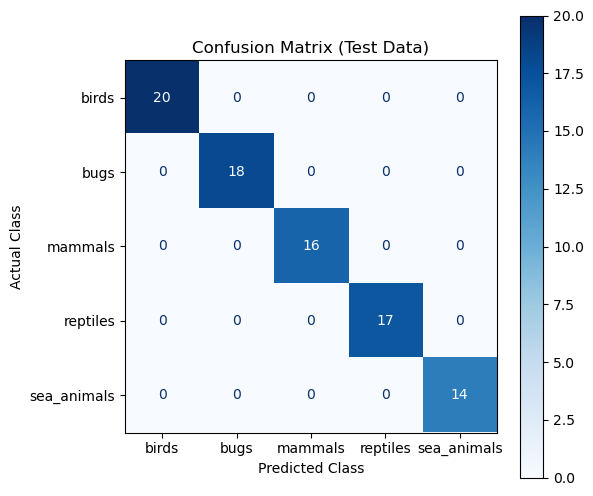

In [34]:
cm = confusion_matrix(y_test.cpu().numpy(), preds_test.numpy())

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=groups)
disp.plot(ax=ax, cmap="Blues", values_format="d")

ax.set_xlabel("Predicted Class")
ax.set_ylabel("Actual Class")
ax.set_title("Confusion Matrix (Test Data)")
plt.show()


In [35]:
classifyNewImage('PCA_images/alligator2_original_.jpg')

Batch 0/1
Image: PCA_images/alligator2_original_.jpg
Predicted group: reptiles (85.1% confidence)
Class probabilities:
         birds: 0.9%
          bugs: 1.3%
       mammals: 4.9%
      reptiles: 85.1%
   sea_animals: 7.8%


('reptiles',
 array([0.00872273, 0.01326812, 0.04920544, 0.850814  , 0.07798979],
       dtype=float32))

In [ ]:
classifyNewImage('PCA_images/alligator2_1_8_.jpg')

In [ ]:
classifyNewImage('PCA_images/beetle_original.jpg')

In [ ]:
classifyNewImage('PCA_images/beetle_0_10.jpg')

In [ ]:
classifyNewImage('PCA_images/beetle_10_15.jpg')

In [ ]:
classifyNewImage('PCA_images/elephant7_original_.jpg')

In [ ]:
classifyNewImage('PCA_images/elephant_1_5_.jpg')

In [ ]:
classifyNewImage('PCA_images/hawk5_original_.jpg')

In [ ]:
classifyNewImage('PCA_images/hawk5_1_5_.jpg')

In [20]:
results= pd.DataFrame(classificationResults)
results

,image,path,pred_group,confidence_pct
0,alligator2_original_.jpg,PCA_images/alligator2_original_.jpg,reptiles,85.019684
1,alligator2_1_8_.jpg,PCA_images/alligator2_1_8_.jpg,reptiles,68.069148
2,beetle_original.jpg,PCA_images/beetle_original.jpg,bugs,95.490265
3,beetle_0_10.jpg,PCA_images/beetle_0_10.jpg,bugs,84.802097
4,beetle_10_15.jpg,PCA_images/beetle_10_15.jpg,bugs,61.293793
5,elephant7_original_.jpg,PCA_images/elephant7_original_.jpg,mammals,95.410377
6,elephant_1_5_.jpg,PCA_images/elephant_1_5_.jpg,mammals,93.283194
7,hawk5_original_.jpg,PCA_images/hawk5_original_.jpg,birds,95.783722
8,hawk5_1_5_.jpg,PCA_images/hawk5_1_5_.jpg,birds,90.796012
